# Disaster Response: Machine learning pipeline

In this notebook, we use the SQLite database generated from our ETL_pipeline_Preparation notebook, to create a machine learning pipeline to categorize the disaster response events.

In [1]:
# import libraries
import pandas as pd
from sqlalchemy import create_engine
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns
import warnings
import sys
import os
import re
import pickle

warnings.simplefilter('ignore')

In [2]:
# load data from database
engine = create_engine('sqlite:///disaster_response.db')
df = pd.read_sql_table('disaster_response', engine)

In [3]:
#print few row of
df.head()

,id,message,original,genre,related,request,offer,aid_related,medical_help,medical_products,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,2,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct,1,0,0,1,0,0,...,0,0,1,0,1,0,0,0,0,0
2,8,Looking for someone but no name,"Patnm, di Maryani relem pou li banm nouvel li ...",direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9,UN reports Leogane 80-90 destroyed. Only Hospi...,UN reports Leogane 80-90 destroyed. Only Hospi...,direct,1,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
4,12,"says: west side of Haiti, rest of the country ...",facade ouest d Haiti et le reste du pays aujou...,direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
#defining feature and target variable
X = df['message'] #feature variable
y = df.iloc[:,4:] #target variables

In [5]:
#print the first message
X[0]

'Weather update - a cold front from Cuba that could pass over Haiti'

In [6]:
print("Size of target variable is {}".format(y.shape))
print("Size of feature variable is {}".format(X.shape))


Size of target variable is (26028, 35)
Size of feature variable is (26028,)


In [7]:
summand = y.sum()

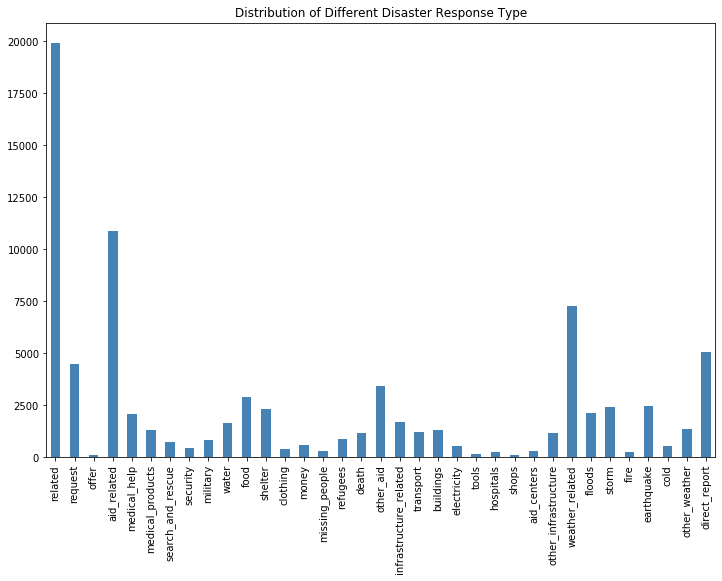

In [8]:
#create visual
plt.figure(figsize=(12,8))
summand.plot(kind='bar', color = 'steelblue')
plt.title("Distribution of Different Disaster Response Type");
#plt.savefig("DisasterResponseTypes.png",dpi=300)

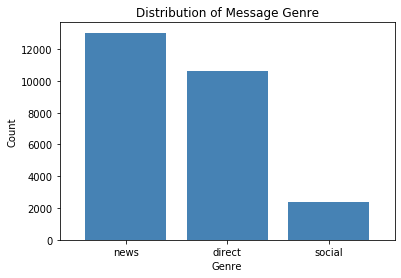

In [9]:
#view distribution of the different ways messages were sent during disaster
df['genre'].value_counts().plot(kind='bar', width=0.8,color = 'steelblue');
plt.title('Distribution of Message Genre')
plt.xlabel('Genre');
plt.ylabel('Count');
plt.xticks(rotation = 0);

### 2. Write a tokenization function to process your text data

The feature variable is a text data and will need to be processed before we can feed it into our model.

In [10]:
#import libraries for our text processing
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
warnings.simplefilter('ignore')

import re


[nltk_data] Downloading package punkt to /Users/marvellousonuma-
[nltk_data]     kalu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/marvellousonuma-
[nltk_data]     kalu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/marvellousonuma-
[nltk_data]     kalu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [11]:
stop_words = stopwords.words("english")
lemmatizer = WordNetLemmatizer()
stemming = PorterStemmer()

def tokenize(text):
    """
    A function that processes our text data
    INPUT: takes as input a string of text 
    
    OUTPUT:
    list of clean tokens (words)
    """
    #search for urls in message and replace with urlplaceolder
    #url_rgex is the regular expression to find urls
    url_regex = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    detected_urls = re.findall(url_regex, text)
    for url in detected_urls:
        text = text.replace(url, "urlplaceholder")
        
    
    #Normalization & capitalization:
    
    text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower())
    

    # Tokenize text: split into words
     
    words = word_tokenize(text)
  
    
    # Remove stop words
    words = [w for w in words if w not in stop_words]
     # lemmatize as shown in the lesson
    
    clean_tokens = []
    for tok in words:
        clean_tok = lemmatizer.lemmatize(tok).lower().strip()
        clean_tokens.append(clean_tok)
    

    return clean_tokens

In [12]:
#test the tokenize function
print("Message without tokenize function:")
print(X[0])

print("\nTokenized message:")
print(tokenize(X[0]))

Message without tokenize function:
Weather update - a cold front from Cuba that could pass over Haiti

Tokenized message:
['weather', 'update', 'cold', 'front', 'cuba', 'could', 'pas', 'haiti']


### 3. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. Since there are multiple target variables, the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) will be helpful for our prediction

In [13]:
#import libraries for our ML model

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer


In [14]:
#create the first ML Pipeline using AdaBoostClassifier 
pipeline_Adaboost =  Pipeline([
        ('vect', CountVectorizer(tokenizer=tokenize)),
        ('tfidf', TfidfTransformer()),
        ('clf', MultiOutputClassifier(AdaBoostClassifier()))
    ])

### 4. Train, Test, Split

Split data into train and test sets

In [15]:
#import library
from sklearn.model_selection import train_test_split

#split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y)
#print size of split data
X_train.shape, y_train.shape, y.shape, X.shape

((19521,), (19521, 35), (26028, 35), (26028,))

### 5. Train model

In [16]:
# train model
pipe_Adaboost = pipeline_Adaboost.fit(X_train, y_train)

### 6. Test your model
Report the f1 score, precision and recall for each output category of the dataset. We will iterate through the columns and call sklearn's `classification_report` on each.

In [17]:
from sklearn.metrics import classification_report

def performance_report(model,X_true,y_true):
    """
    Function to generate classification report on a model
    INPUT: Model, true data sets, that is X_test & y_test data sets
    OUTPUT: Prints the f1 score, precision and recall for each output category
    """
    y_pred = model.predict(X_true)
    for i, col in enumerate(y_true):
        print(col)
        print(classification_report(y_true[col], y_pred[:, i]))

In [18]:
performance_report(pipe_Adaboost, X_test, y_test)

related
              precision    recall  f1-score   support

           0       0.70      0.17      0.28      1532
           1       0.79      0.98      0.88      4975

    accuracy                           0.79      6507
   macro avg       0.75      0.58      0.58      6507
weighted avg       0.77      0.79      0.74      6507

request
              precision    recall  f1-score   support

           0       0.91      0.96      0.94      5415
           1       0.74      0.53      0.62      1092

    accuracy                           0.89      6507
   macro avg       0.82      0.74      0.78      6507
weighted avg       0.88      0.89      0.88      6507

offer
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6475
           1       0.00      0.00      0.00        32

    accuracy                           0.99      6507
   macro avg       0.50      0.50      0.50      6507
weighted avg       0.99      0.99      0.99      650

### 7. Improve your model
Use grid search to find better parameters. 

In [19]:
from sklearn.model_selection import GridSearchCV

In [ ]:
#pipe_Adaboost.get_params()

In [20]:
parameters = {
              'clf__estimator__n_estimators': [10,25,50],
              'clf__estimator__learning_rate': [0.5, 1, 1.5],
              'tfidf__use_idf': (True, False)
            
             }

#parameters_grid = {'classifier__estimator__n_estimators': [10, 20, 40]}

#f1 = make_scorer(f1_score , average='macro')
cv_Adaboost = GridSearchCV(pipe_Adaboost, param_grid=parameters)


### 8. Test your model
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

In [21]:
# Find best parameters
cv_Adaboost.fit(X_train, y_train)
performance_report(cv_Adaboost, X_test, y_test)

related
              precision    recall  f1-score   support

           0       0.76      0.12      0.21      1532
           1       0.78      0.99      0.87      4975

    accuracy                           0.78      6507
   macro avg       0.77      0.55      0.54      6507
weighted avg       0.78      0.78      0.72      6507

request
              precision    recall  f1-score   support

           0       0.90      0.98      0.94      5415
           1       0.79      0.47      0.59      1092

    accuracy                           0.89      6507
   macro avg       0.85      0.72      0.76      6507
weighted avg       0.88      0.89      0.88      6507

offer
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6475
           1       0.00      0.00      0.00        32

    accuracy                           0.99      6507
   macro avg       0.50      0.50      0.50      6507
weighted avg       0.99      0.99      0.99      650

### 9. Try improving your model further.
Here we will trythe RanDomforestClassifier ML algorithm

In [22]:
#second pipeline 
pipeline_RandomForest =  Pipeline([
        ('vect', CountVectorizer(tokenizer=tokenize)),
        ('tfidf', TfidfTransformer()),
        ('clf', MultiOutputClassifier(RandomForestClassifier()))
    ])

In [23]:
pipe_RandomForest = pipeline_RandomForest.fit(X_train, y_train)
performance_report(pipe_RandomForest, X_test, y_test)

related
              precision    recall  f1-score   support

           0       0.72      0.39      0.51      1532
           1       0.84      0.95      0.89      4975

    accuracy                           0.82      6507
   macro avg       0.78      0.67      0.70      6507
weighted avg       0.81      0.82      0.80      6507

request
              precision    recall  f1-score   support

           0       0.91      0.98      0.94      5415
           1       0.83      0.52      0.64      1092

    accuracy                           0.90      6507
   macro avg       0.87      0.75      0.79      6507
weighted avg       0.90      0.90      0.89      6507

offer
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6475
           1       0.00      0.00      0.00        32

    accuracy                           1.00      6507
   macro avg       0.50      0.50      0.50      6507
weighted avg       0.99      1.00      0.99      650

In [24]:
#tunning parameters
parameter2 = {'tfidf__use_idf': (True, False),
              'clf__estimator__n_estimators': [10,25,50],
              'clf__estimator__min_samples_split': [2,3,4]
              
             }

#parameters_grid = {'classifier__estimator__n_estimators': [10, 20, 40]}

#f1 = make_scorer(f1_score , average='macro')
cv_RandomForest = GridSearchCV(pipeline_RandomForest, param_grid=parameter2)

In [25]:
# Find best parameters
cv_RandomForest.fit(X_train, y_train);
performance_report(cv_RandomForest, X_test, y_test)

related
              precision    recall  f1-score   support

           0       0.72      0.38      0.49      1532
           1       0.83      0.96      0.89      4975

    accuracy                           0.82      6507
   macro avg       0.78      0.67      0.69      6507
weighted avg       0.81      0.82      0.80      6507

request
              precision    recall  f1-score   support

           0       0.91      0.98      0.94      5415
           1       0.84      0.52      0.65      1092

    accuracy                           0.90      6507
   macro avg       0.88      0.75      0.80      6507
weighted avg       0.90      0.90      0.89      6507

offer
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6475
           1       0.00      0.00      0.00        32

    accuracy                           1.00      6507
   macro avg       0.50      0.50      0.50      6507
weighted avg       0.99      1.00      0.99      650

              precision    recall  f1-score   support

           0       0.95      1.00      0.97      6180
           1       0.51      0.06      0.10       327

    accuracy                           0.95      6507
   macro avg       0.73      0.53      0.54      6507
weighted avg       0.93      0.95      0.93      6507

direct_report
              precision    recall  f1-score   support

           0       0.86      0.97      0.92      5258
           1       0.77      0.36      0.49      1249

    accuracy                           0.86      6507
   macro avg       0.82      0.67      0.70      6507
weighted avg       0.85      0.86      0.83      6507



In [27]:
#finding the best paramesters based on grid search
print(cv_RandomForest.best_params_)

{'clf__estimator__min_samples_split': 2, 'clf__estimator__n_estimators': 50, 'tfidf__use_idf': False}


In [28]:
optimised_model = cv_RandomForest.best_estimator_
print (optimised_model)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=<function tokenize at...
                                                                        ccp_alpha=0.0,
                                                                        class_weight=None,
                                                                        criterion='gini',
                                                                   

### 10. Export model as a pickle file

In [29]:
# Pickle best model
with open('train_classifier.pkl', 'wb') as f:
    pickle.dump(optimised_model, f)